In [34]:
import os
import sys
from pprint import pprint
from dotenv import load_dotenv
import pandas as pd
import numpy as np
#import seaborn as sns
#import time
import xgboost as xgb
from xgboost import plot_tree
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import operator
import random
import graphviz
#conda install -c conda-forge bayesian-optimization
from bayes_opt import BayesianOptimization
import pandas_profiling
load_dotenv('forecast_arosa.env')
random.seed(22)

# Open CSV


In [13]:
path_in = os.getenv('DATAIN') # this is where we downloaded the tabel

In [14]:
file_name = os.getenv('DATASET_FILENAME') # this is where we downloaded the tabel

In [15]:
os.path.join(path_in, file_name)

'../arosa_data/arosa_data_feature1.csv'

In [16]:
df = pd.read_csv(os.path.join(path_in, file_name),delimiter=';')

In [17]:
df[df['Datum']=='31.08.2019']

Datum Wochentag  TagNr  WocheNr  isFreiZH  isFreiSG  isFreiGR  \
1338  31.08.2019   Samstag   1339       35         1         1         1   

      isFerienZH Ferien Desc ZH  IsFerienZH_plus3  ...  precip_1h_mm_sum  \
1338           0            NaN                 0  ...              0.03   

      fresh_snow_1h_cm_sum wind_speed_mean_10m_1h_ms_avg  \
1338                   0.0                           5.8   

      weather_symbol_1h_idx_spe  number_of_events  isHumorfestival Schalter  \
1338                        2.9                 3                0      183   

      Tel  Mail Total Anfragen  
1338   33    23            239  

[1 rows x 54 columns]

In [18]:
len(df)

1339

# Overview of Data

In [8]:
df.profile_report()

# Preprocessing

In [19]:
# df['Total Anfragen'].replace('-', 0)
df[df['Total Anfragen']=='-']
#df.astype({'Total Anfragen': 'int32'}).dtypes

Empty DataFrame
Columns: [Datum, Wochentag, TagNr, WocheNr, isFreiZH, isFreiSG, isFreiGR, isFerienZH, Ferien Desc ZH, IsFerienZH_plus3, isFerienZH_minus3, isFerienSG, Ferien Desc SG, IsFerienSG_plus3, isFerienSG_minus3, isFerienGR, Ferien Desc GR, IsFerienGR_plus3, isFerienGR_minus3, Feiertag Desc, isFeiertag ZH, IsFeiertagZH_plus3, isFeiertagZH_minus3, isFeiertag SG, IsFeiertagSG_plus3, isFeiertagSG_minus3, isFeiertag GR, IsFeiertagGR_plus3, isFeiertagGR_minus3, t_2m_c_avg, snow_depth_cm_avg, visibility_m_avg, wind_speed_10m_ms_max, prob_precip_1h_p_avg, prob_tstorm_1h_p_avg, hail_idx_avg, wind_gusts_10m_ms_max, wind_speed_mean_10m_24h_ms_avg, t_max_2m_24h_c_max, t_min_2m_24h_c_min, precip_24h_mm_max, fresh_snow_24h_cm_max, is_sleet_1h_idx_max, is_fog_1h_idx_max, precip_1h_mm_sum, fresh_snow_1h_cm_sum, wind_speed_mean_10m_1h_ms_avg, weather_symbol_1h_idx_spe, number_of_events, isHumorfestival, Schalter, Tel, Mail, Total Anfragen]
Index: []

[0 rows x 54 columns]

In [20]:
df['Total Anfragen'].dtypes

dtype('int64')

In [35]:
target_variable = 'Schalter'
col_names= list(df)
col_names.remove(target_variable)
col_names

['Datum',
 'Wochentag',
 'TagNr',
 'WocheNr',
 'isFreiZH',
 'isFreiSG',
 'isFreiGR',
 'isFerienZH',
 'Ferien Desc ZH',
 'IsFerienZH_plus3',
 'isFerienZH_minus3',
 'isFerienSG',
 'Ferien Desc SG',
 'IsFerienSG_plus3',
 'isFerienSG_minus3',
 'isFerienGR',
 'Ferien Desc GR',
 'IsFerienGR_plus3',
 'isFerienGR_minus3',
 'Feiertag Desc',
 'isFeiertag ZH',
 'IsFeiertagZH_plus3',
 'isFeiertagZH_minus3',
 'isFeiertag SG',
 'IsFeiertagSG_plus3',
 'isFeiertagSG_minus3',
 'isFeiertag GR',
 'IsFeiertagGR_plus3',
 'isFeiertagGR_minus3',
 't_2m_c_avg',
 'snow_depth_cm_avg',
 'visibility_m_avg',
 'wind_speed_10m_ms_max',
 'prob_precip_1h_p_avg',
 'prob_tstorm_1h_p_avg',
 'hail_idx_avg',
 'wind_gusts_10m_ms_max',
 'wind_speed_mean_10m_24h_ms_avg',
 't_max_2m_24h_c_max',
 't_min_2m_24h_c_min',
 'precip_24h_mm_max',
 'fresh_snow_24h_cm_max',
 'is_sleet_1h_idx_max',
 'is_fog_1h_idx_max',
 'precip_1h_mm_sum',
 'fresh_snow_1h_cm_sum',
 'wind_speed_mean_10m_1h_ms_avg',
 'weather_symbol_1h_idx_spe',
 'number_

In [36]:
df1 = df.dropna(subset=[target_variable])

In [37]:
nulls_per_column = df.isnull().sum()
print(nulls_per_column)

Datum                                0
Wochentag                            0
TagNr                                0
WocheNr                              0
isFreiZH                             0
isFreiSG                             0
isFreiGR                             0
isFerienZH                           0
Ferien Desc ZH                    1024
IsFerienZH_plus3                     0
isFerienZH_minus3                    0
isFerienSG                           0
Ferien Desc SG                    1042
IsFerienSG_plus3                     0
isFerienSG_minus3                    0
isFerienGR                           0
Ferien Desc GR                     998
IsFerienGR_plus3                     0
isFerienGR_minus3                    0
Feiertag Desc                     1194
isFeiertag ZH                        0
IsFeiertagZH_plus3                   0
isFeiertagZH_minus3                  0
isFeiertag SG                        0
IsFeiertagSG_plus3                   0
isFeiertagSG_minus3      

In [38]:
col_names= list(df)
col_names.remove(target_variable)
col_names.remove('Tel')
col_names.remove('Mail')
col_names.remove('Total Anfragen')
df = df.dropna(subset=[target_variable])
X, y = df[col_names],df[target_variable]
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=123)
X_test, X_val, y_test, y_val= train_test_split(X_test, y_test, test_size=0.5, random_state=123)

# XGBoost Model

In [39]:
params1 = {'n_jobs': 8 }

pipeline1 = Pipeline([
                     ("vectorizer", DictVectorizer(sort=False)),
                     ("clf", xgb.XGBRegressor(**params1, objective='reg:squarederror')) 
                    ])

xgb_fit = pipeline1.fit(X_train.to_dict("records"), y_train)

In [40]:
def mape_vectorized_v2(a, b): 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()

In [41]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [42]:
#Computing the MAE of our predictions
preds = xgb_fit.predict(X_test.to_dict("records"))
print("Mean Absolute Error : " + str(mean_absolute_error(preds, y_test)))
print("Mean Squared Error : " + str(mean_squared_error(preds, y_test)))
print("Mean Absolute Percentage Error : " + str(mape_vectorized_v2(preds, y_test)))
print("Mean Absolute Percentage Error : " + str(mean_absolute_percentage_error(y_test, preds)))

Mean Absolute Error : 15.003426867337962
Mean Squared Error : 624.9666723339792
Mean Absolute Percentage Error : 0.48750328276820126
Mean Absolute Percentage Error : inf


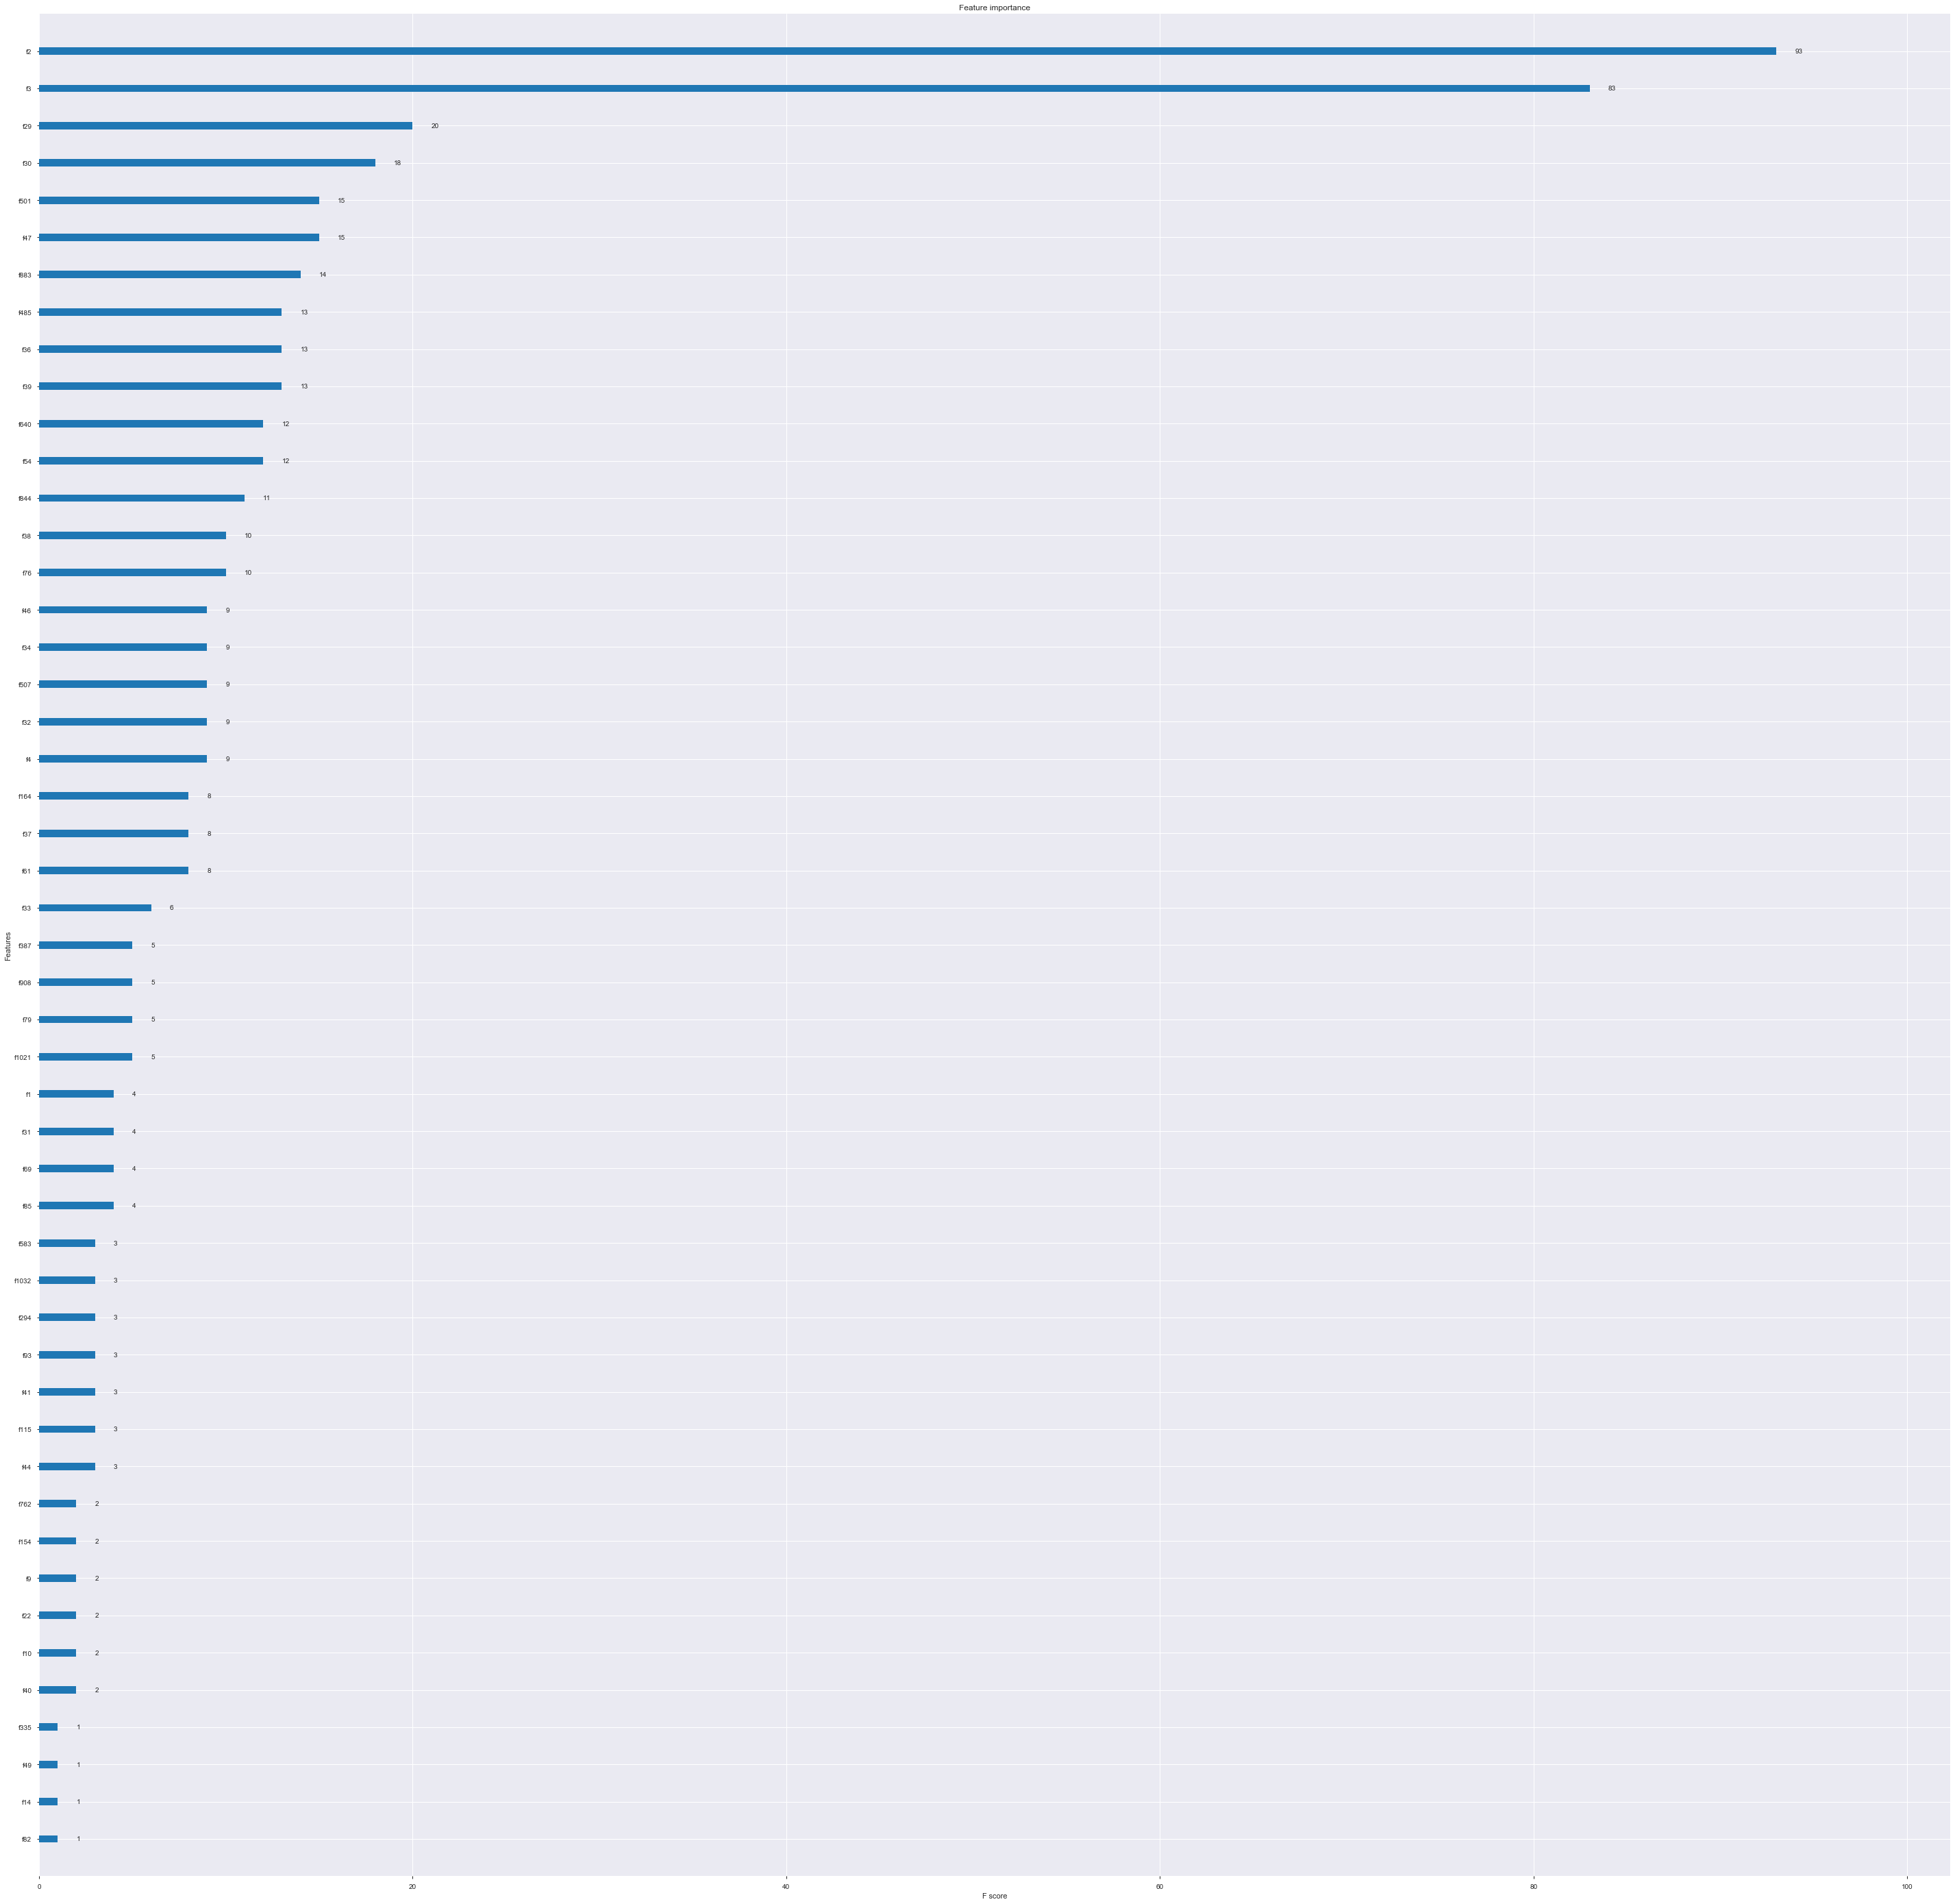

In [43]:
xgb.plot_importance(pipeline1._final_estimator)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

In [44]:
pipeline1.named_steps['vectorizer'].vocabulary_

{'Datum=05.06.2019': 0,
 'Wochentag=Mittwoch': 1,
 'TagNr': 2,
 'WocheNr': 3,
 'isFreiZH': 4,
 'isFreiSG': 5,
 'isFreiGR': 6,
 'isFerienZH': 7,
 'Ferien Desc ZH': 8,
 'IsFerienZH_plus3': 9,
 'isFerienZH_minus3': 10,
 'isFerienSG': 11,
 'Ferien Desc SG': 12,
 'IsFerienSG_plus3': 13,
 'isFerienSG_minus3': 14,
 'isFerienGR': 15,
 'Ferien Desc GR': 16,
 'IsFerienGR_plus3': 17,
 'isFerienGR_minus3': 18,
 'Feiertag Desc': 19,
 'isFeiertag ZH': 20,
 'IsFeiertagZH_plus3': 21,
 'isFeiertagZH_minus3': 22,
 'isFeiertag SG': 23,
 'IsFeiertagSG_plus3': 24,
 'isFeiertagSG_minus3': 25,
 'isFeiertag GR': 26,
 'IsFeiertagGR_plus3': 27,
 'isFeiertagGR_minus3': 28,
 't_2m_c_avg': 29,
 'snow_depth_cm_avg': 30,
 'visibility_m_avg': 31,
 'wind_speed_10m_ms_max': 32,
 'prob_precip_1h_p_avg': 33,
 'prob_tstorm_1h_p_avg': 34,
 'hail_idx_avg': 35,
 'wind_gusts_10m_ms_max': 36,
 'wind_speed_mean_10m_24h_ms_avg': 37,
 't_max_2m_24h_c_max': 38,
 't_min_2m_24h_c_min': 39,
 'precip_24h_mm_max': 40,
 'fresh_snow_24h_

In [45]:
def train_model(max_depth, 
                n_estimators,
                learning_rate):
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'learning_rate':learning_rate,
        'n_jobs': 8 #number of CPU threads
    }

    pipeline = Pipeline([
                     ("vectorizer", DictVectorizer(sort=False)),
                     ("clf", xgb.XGBRegressor(objective = 'reg:squarederror',**params)),

                        ])

    xgb_fit = pipeline.fit(X_train.to_dict("records"), y_train)
    preds = xgb_fit.predict(X_val.to_dict("records"))
    mse = mean_absolute_error(preds, y_test)
    return -mse

bounds = {
    'max_depth':(5,100),
    'n_estimators': (100,10000),
    'learning_rate': (.001, 0.1),
}


In [46]:
optimizer = BayesianOptimization(
    f=train_model,
    pbounds=bounds,
    random_state=1,
    verbose=2,
)
best = optimizer.maximize(init_points=2, n_iter= 3)
print(optimizer.max)

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
|  1        | -34.74    |  0.04229  |  73.43    |  101.1    |
|  2        | -35.09    |  0.03093  |  18.94    |  1.014e+0 |
|  3        | -34.74    |  0.1      |  100.0    |  1e+04    |


KeyboardInterrupt: 

In [ ]:
params = {
    'n_estimators': 1000,
    'max_depth': 100,
    'learning_rate':0.001,
    'n_jobs': 8 #number of CPU threads
}

pipeline = Pipeline([
                 ("vectorizer", DictVectorizer(sort=False)),
                 ("clf", xgb.XGBRegressor(objective = 'reg:squarederror',**params)),

                    ])

xgb_fit = pipeline.fit(X_train.to_dict("records"), y_train)
preds = xgb_fit.predict(X_val.to_dict("records"))
mse = mean_absolute_error(preds, y_test)
mse

In [ ]:
params2 = {
    'n_estimators': int(optimizer.max['params']['n_estimators']),
    'pos_weight': pos_weight,
    'max_depth': int(optimizer.max['params']['max_depth']),
    'learning_rate':optimizer.max['params']['learning_rate'],
    'n_jobs': 4 #number of CPU threads
}

pipeline2 = Pipeline([
                     ("vectorizer", DictVectorizer(sort=False)),
                     ("clf", xgb.XGBRegressor(**params2))
                    ])

xgb_tuned_fit = pipeline2.fit(X_train.to_dict("records"), y_train)

In [ ]:
preds_tuned = xgb_tuned_fit.predict(X_test.to_dict("records"))
preds_tuned_prob = xgb_tuned_fit.predict_proba(X_test.to_dict("records"))[:,1]
accuracy = float(np.sum(preds_tuned==y_test))/y_test.shape[0] 
print("accuracy xgb_tuned_fit: %f" % (accuracy))